# 循环神经网络（RNN）笔记
## 1 简要信息
循环神经网络的每一层不仅由上一层的输入决定，还由上一时刻当前层决定。故循环神经网络能够对时序信息有较好的拟合性。
![rnn](https://pic1.zhimg.com/80/v2-8f534b5db1f3d8a5c4ccd029be4a15b4_720w.webp)
\
可使用现成的循环神经网络`pytorch.nn.RNN`进行时序预测。
每一层的计算为：${h_t} = \tanh ({x_t}W_{ih}^T + {b_{ih}} + {h_{t - 1}}W_{hh}^T + {b_{hh}})$。参考文档:[pytorch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html?highlight=rnn#torch.nn.RNN)。
## 2 代码实现
### 2.1 导入

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

### 2.2 神经网络

In [2]:
input_size = 1
hidden_size = 16
output_size = 1
forcast_length=30

class Net(nn.Module):

    def __init__(self, ):
        super(Net, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        for p in self.rnn.parameters():
          nn.init.normal_(p, mean=0.0, std=0.001)

        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):

       out, hidden_prev = self.rnn(x, hidden_prev)
       # [b, seq, h]
       out = out.view(-1, hidden_size)
       out = self.linear(out)
       out = out.unsqueeze(dim=0)
       return out, hidden_prev

lr=0.0001
time_step=50

### 2.3 GPU训练

In [3]:
if(torch.cuda.is_available()):
    device='cuda'
    print("Cuda Apply!")
else:
    device='cpu'

Cuda Apply!


### 2.4 学习

In [4]:
#net = nn.RNN(input_size=1, hidden_size=16,num_layers=1,batch_first=True)
net=Net()
net.to(device)
lossfunction = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr)

hidden = torch.zeros(1,1, 16)
hidden=hidden.to(device)

for iter in range(10000):
    ranspot=np.random.randint((int)(forcast_length/5),size=1)[0]
    Xasix=np.linspace(ranspot,ranspot+forcast_length,time_step)
    data=np.sin(Xasix)
    data=data*np.exp(-Xasix/10)

    data.reshape(time_step,1)
    #数据集
    x=torch.tensor(data[:-1]).float().view(1,time_step-1,1)
    y=torch.tensor(data[1:]).float().view(1,time_step-1,1)
    x=x.to(device)
    y=y.to(device)

    output,hidden=net(x,hidden)

#    output = output.view(-1, 16)
#    aff=nn.Linear(16,1)
#    output = aff(output)
#    output = output.unsqueeze(dim=0)

    hidden=hidden.detach()
    loss=lossfunction(output,y)
    net.zero_grad()
    loss.backward()
    optimizer.step()

    if(iter%100 == 0):
        print("Step:{},loss:{}".format(iter,loss.item()))


Step:0,loss:0.029322514310479164
Step:100,loss:0.06518818438053131
Step:200,loss:0.07586812973022461
Step:300,loss:0.03262605890631676
Step:400,loss:0.05458606034517288
Step:500,loss:0.01946837827563286
Step:600,loss:0.04484555125236511
Step:700,loss:0.014704450033605099
Step:800,loss:0.01384085975587368
Step:900,loss:0.024355219677090645
Step:1000,loss:0.0222757738083601
Step:1100,loss:0.01947116106748581
Step:1200,loss:0.005568923894315958
Step:1300,loss:0.004363061394542456
Step:1400,loss:0.008860847912728786
Step:1500,loss:0.006464438047260046
Step:1600,loss:0.006209542043507099
Step:1700,loss:0.015156352892518044
Step:1800,loss:0.007260446436703205
Step:1900,loss:0.00833151675760746
Step:2000,loss:0.0064187864772975445
Step:2100,loss:0.0018841448472812772
Step:2200,loss:0.00633411668241024
Step:2300,loss:0.011014576070010662
Step:2400,loss:0.0020145555026829243
Step:2500,loss:0.0017285229405388236
Step:2600,loss:0.0038073472678661346
Step:2700,loss:0.0010984486434608698
Step:2800,

### 2.5 验证

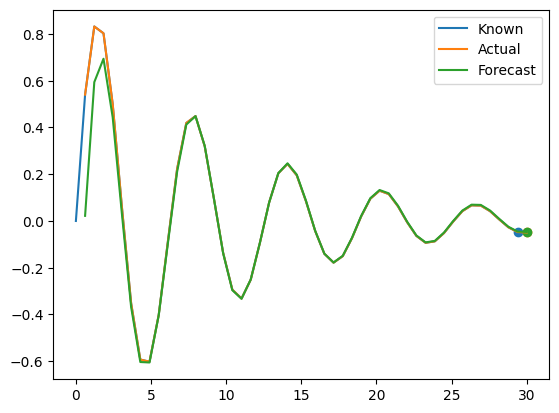

In [5]:
Xasix = np.linspace(0, 0 + forcast_length, time_step)
data=np.sin(Xasix)

data=data*np.exp(-Xasix/10)

data.reshape(time_step,1)
#数据集
x=torch.tensor(data[:-1]).float().view(1,time_step-1,1)
y=torch.tensor(data[1:]).float().view(1,time_step-1,1)
x=x.to(device)
y=y.to(device)

input=x
predict,hidden=net(input,hidden)


x=x.to('cpu')
y=y.to('cpu')
predict =predict.to('cpu')

x = x.data.numpy().ravel()
y = y.data.numpy().ravel()
predict = predict.data.numpy().ravel()

plt.plot(Xasix[:-1],x,label='Known')
plt.plot(Xasix[1:],y,label='Actual')
plt.plot(Xasix[1:],predict,label='Forecast')
plt.scatter(Xasix[time_step-2],x[time_step-2])
plt.scatter(Xasix[time_step-1],y[time_step-2])
plt.scatter(Xasix[time_step-1],predict[time_step-2])
plt.legend(loc=0)
#plt.plot(x.predict)
plt.show()

### 2.6 结果
最后一个预测数据与准确值相差不大。
## 3 思考与问题

### 3.1思考
example.一次预测可以使用0-49号的数据预测出2-50号的值，再将预测值输入神经网络预测3-51号数据，以此类推。
### 3.2 问题
RNN是否能实现概率预测？给出预测准确概率？